<h1><center><a href="https://tblock.github.io/10kGNAD/">Ten Thousand German News Articles Dataset (10kGNAD )</a></center></h1>
<h2><center>NLP Project work, FHNW Brugg</center></h2>
<h3><center>RNN Classifier</center></h3>
<h4><center>Claudio Schmidli</center></h4>
<h4><center>30.06.2023</center></h4>





<p align="justify">
In this notebook, the primary objective is to construct a Recurrent Neural Network (RNN) based text classifier on the  <a href="https://tblock.github.io/10kGNAD/">10kGNAD</a> dataset. A key aspect of this model is the use of pretrained word embeddings, which leverages the concept of <a href="https://machinelearningmastery.com/transfer-learning-for-deep-learning">transfer learning</a> in Natural Language Processing (NLP).
</p>

<p align="justify">

</p>

<p align="justify">


<p align="justify">

</p>



# 1. Load modules and prepare notebook

In [26]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/NLP/Project/'
!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level
from fhnw.nlp.utils.colab import runs_on_colab
from fhnw.nlp.utils.system import system_info
from fhnw.nlp.utils.preprocess import preprocess
from fhnw.nlp.utils.text import clean_text
from fhnw.nlp.utils.ploting import plot_history
from fhnw.nlp.utils.params import build_model_rnn
from fhnw.nlp.utils.params import build_preprocessed_dataset
from fhnw.nlp.utils.params import compile_model
from fhnw.nlp.utils.params import create_label_binarizer_and_set
from fhnw.nlp.utils.params import create_text_preprocessor
from fhnw.nlp.utils.params import dataframe_to_dataset
from fhnw.nlp.utils.params import extract_embedding_layer_and_set
from fhnw.nlp.utils.params import extract_text_vectorization_and_set
from fhnw.nlp.utils.params import extract_vocabulary_and_set
from fhnw.nlp.utils.params import get_train_test_split
from fhnw.nlp.utils.params import re_compile_model
from fhnw.nlp.utils.params import save_model
from fhnw.nlp.utils.params import train_model
from fhnw.nlp.utils.params import predict_classification
from fhnw.nlp.utils.ploting import report_classification_results

import random
random.seed(1)
from tqdm.notebook import tqdm
from modules.plotmodels import PlotLearning, plot_learning_schedule, macro_f1_score

import pandas as pd
import numpy as np

set_log_level(2)
import tensorflow as tf

from IPython.display import clear_output

from nltk.corpus import stopwords
import nltk

#print(system_info())

# 2. Downoald the data

In [2]:
%%time
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

# Load test set
file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)

#Add train/test labels
data_train["split"] = "train"
data_test["split"] = "test"

#Merge train and test data into a variable named data_all
data = pd.concat([data_train, data_test])

#data.head(3)

CPU times: user 302 ms, sys: 77.5 ms, total: 380 ms
Wall time: 393 ms


# 3. Pre-processing
Let's preprocess the text first by using the following steps:
- text cleaning
- tokenization
- compound word splitting
- stemming
- stop word removal

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words("german"))
# analyze and revise stopwords
stopwords.add("sehr")
stopwords.add("viel")
stopwords.add("nächst")
stopwords.add("leider")

# Apply the preprocess function to each row in the 'text_original' column
data['token_clean'] = data['text_original'].apply(lambda x: preprocess(x, stopwords=stopwords, do_compound_word_split=True))
data['text_clean'] = data['text_original'].apply(lambda x: clean_text(x))

INFO:compound_split.doc_split:102 known words loaded


# 4. Create model
In the next section of my project, I will be focusing on creating the RNN model. To begin, I'll set up a params dictionary, which serves as a central repository for specifying various hyperparameters and making design choices for the model. This structured approach not only aids in organizing my model's configuration but also lays a foundational framework for potential hyperparameter tuning and model optimization later on, although it's not included in this current notebook.

The params dictionary includes settings such as verbosity, data shuffling, the number of samples, batch size, and column names for features and labels. Importantly, it allows for the experimentation with different types of word embeddings, including FastText, Word2Vec, spaCy models, and TensorFlow Hub. The embedding dimension and whether the embedding is trainable are also configurable.

Given the limitations of certain environments like Colab in handling large files, I'll make adjustments to the embedding model based on the platform's capabilities. For instance, in Colab, I will opt for a smaller FastText model.



In [4]:
params = {
    "verbose": True,
    "shuffle": True,
    "n_samples": len(data),
    # modify batch_size in case you experience memory issues
    "batch_size": 128,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    # modify to try different word embeddings
    "embedding_type": "fasttext",
    "embedding_dim": 300,
    "embedding_trainable": False,
    "embedding_fasttext_model": "cc.de.300.bin",
    "embedding_word2vec_model_url": "https://cloud.devmount.de/d2bc5672c523b086/german.model",
    "embedding_spacy_model": "de_core_news_md",
    "embedding_tensorflow_hub_url": "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2",
    "model_type": "rnn",
}

if runs_on_colab() and params["embedding_type"] == "fasttext":
    # colab as problems handling such large files
    model_name = "cc.de.50.bin"
    download("https://drive.switch.ch/index.php/s/fncH84BgISMlT3v/download", model_name)
    params["embedding_dim"] = 50
    params["embedding_fasttext_model"] = model_name


The subsequent steps involve initializing and setting up various components crucial for the model:


**Label Binarizer Creation:** I'll create and configure a LabelBinarizer, which will be used for transforming textual labels into a binary format suitable for model training.


**Vocabulary Extraction:** The next step involves extracting the vocabulary from the dataset and storing it in the params dictionary. This is a critical step for text processing and feature extraction.


**Text Vectorization:** I will then create a TextVectorization layer and a vocabulary iterator, which will be responsible for converting text into numerical data that the model can process.


**Embedding Layer Setup:** Finally, I will create an Embedding layer, which is crucial for NLP models as it represents words in a dense vector space. This layer will also be stored in the params dictionary.


Through these steps, I aim to build a robust foundation for the RNN model, ensuring that each component is carefully crafted and integrated, setting the stage for effective model training and evaluation.

In [5]:
#Create an initialized LabelBinarizer
create_label_binarizer_and_set(params, data)
#Extract the vocabulary and put it into the params dictionary
extract_vocabulary_and_set(params, data)
#Create the TextVectorization layer and a vocabulary iterator and put them into the params dictionary
extract_text_vectorization_and_set(params)
#Creates the Embedding layer and puts it into the params dictionary
extract_embedding_layer_and_set(params)


Inferred classification type: multi-class
Median sequence length: 196
Percentil (0.98) cutoff sequence length: 652
Max sequence length: 2813
Used embedding sequence length: 652
Vocabulary length: 82953


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Embedding type: fasttext
Number of null word embeddings: 3
Words not found in total: 3
Words without embedding (3/3): ['', 'yq', 'qz']


In this section of my project, I will be focusing on preparing the data for training the model. This step is crucial as it ensures that the data is in the right format and structure for the model to learn effectively.

Firstly, I'll segment the dataset into training, validation, and testing sets based on the "split" attribute. This segregation is vital to evaluate the model's performance on unseen data accurately.

Once the data is split accordingly, I'll convert these datasets into a format that is compatible with TensorFlow, specifically into TensorFlow datasets. This conversion facilitates efficient data handling and batch processing during model training.

In [6]:
data_train = data[data["split"] == "train"]
data_train, data_val = get_train_test_split(params, data_train)
data_test = data[data["split"] == "test"]
dataset_train = dataframe_to_dataset(params, data_train)
dataset_test = dataframe_to_dataset(params, data_test)
dataset_val = dataframe_to_dataset(params, data_val)

training_preprocessor = create_text_preprocessor(params, True)
dataset_train_preprocessed = build_preprocessed_dataset(params, dataset_train, True, training_preprocessor)
dataset_val_preprocessed = build_preprocessed_dataset(params, dataset_val, False, training_preprocessor)

7396 train examples
1849 test examples


In this part of the notebook, I focus on constructing and training the RNN model. A significant aspect of this process involved manually testing a variety of hyperparameters to optimize the model's performance. A detailed summary of this experimentation is presented in the table below.

For selecting the optimal learning rate, I chose an empirical approach, closely monitoring the model's metric history over time. This method proved more effective than automated hyperparameter tuning, like grid or random searches, primarily because it offered quicker feedback. This real-time observation was crucial for rapid iterations, allowing me to make informed adjustments promptly.

Automated hyperparameter tuning, while comprehensive, can be extremely time-consuming, particularly for models with complex architectures like RNNs. In contrast, my manual approach provided me with deeper insights into the model's behavior and the interplay of different parameters. This hands-on experience has not only enriched my understanding of the model but also honed my intuition, which is invaluable for future machine learning projects.

<br>
<b>Tested hyperparameters</b>
<table>
    <tr>
        <th>Hyperparameter</th>
        <th>Tested Value</th>
        <th>Best Value</th>
    </tr>
    <tr>
        <td>rnn_units</td>
        <td>32, 64, 128</td>
        <td><!-- Best Value Here --></td>
    </tr>
    <tr>
        <td>Number of RNN Layers</td>
        <td>1, 2, 3</td>
        <td>2</td>
    </tr>
    <tr>
        <td>Dropout Rate before global_max_pool</td>
        <td>0, 0.3, 0.5, 0.7</td>
        <td>0.3</td>
    </tr>
    <tr>
        <td>RNN Type (LSTM/GRU)</td>
        <td>LSTM, GRU, RNN</td>
        <td>GRU (simple RNN was too slow for me)</td>
    </tr>
    <tr>
        <td>Learning Rate</td>
        <td>0.01, 0.005, 0.001</td>
        <td>0.01</td>
    </tr>
    <tr>
        <td>Learning Rate Decay</td>
        <td>0.001, 0.0001, 0.00001</td>
        <td>0.001</td>
    </tr>
    <tr>
        <td>Activation Function</td>
        <td>ReLU, Sigmoid</td>
        <td>Sigmoid</td>
    </tr>
    <tr>
        <td>Batch Size</td>
        <td>64, 128</td>
        <td>64</td>
    </tr>
</table>
<br>

An important observation I made during the process of the model training was the effect of batch size on the performance. Initially, I started with a batch size of 128 but later decided to reduce it to 64. This change resulted in a noticeable improvement in performance. I attribute this enhancement to the regularization effect that smaller batch sizes can have. Smaller batches tend to offer more regularization, reducing the likelihood of overfitting on the training data. This is because smaller batch sizes provide a more noisy estimate of the gradient, which can help the model generalize better to unseen data.

For the optimal learning rate, I chose to rely on empirical observation of the model's metric history over time. This allowed me to closely monitor the training process and make adjustments as needed. I found this more effective than automated hyperparameter tuning methods, such as grid or random search, as it gave me a quicker feedback loop. This approach enabled me to adapt and restart the training process efficiently, which was crucial given the time constraints and the need for rapid iteration.

Moreover, automated hyperparameter tuning can be quite time-consuming, especially for models with a large number of parameters and complex architectures like RNNs. By manually tuning and observing the impact of each hyperparameter, I gained deeper insights into the model's behavior and learned how different parameters interact with each other, which I found invaluable. This hands-on experience also allowed me to develop a more intuitive understanding of the model, which can be beneficial for future projects.


In [22]:
params['learning_rate'] = 0.01
params['optimizer_learning_rate_decay'] = 0.001
params['model_metric'] = ["accuracy", macro_f1_score]
params['batch_size'] = 64#128

def build_model_rnn(params):
    """Builds a rnn classifier (only partially) based on the provided params

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    """

    from tensorflow import keras

    # choose the output activation function based on the classification type
    classification_type = params.get("classification_type", "binary")
    if classification_type == "binary":
        output_activation = "sigmoid"
    elif classification_type == "multi-class":
        output_activation = "softmax"
    elif classification_type == "multi-label":
        output_activation = "sigmoid"
    else:
        raise TypeError("Unknown classification_type "+classification_type)

    X_column_name = params.get("X_column_name", "text_clean")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    vectorize_layer = params[computed_objects_column_name]["vectorize_layer"]
    embedding_layer = params[computed_objects_column_name]["embedding_layer"]
    label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    output_classes = len(label_binarizer.classes_)
    output_classes = output_classes if output_classes > 2 else 1


    # Build a separate model for training
    model_train = keras.Sequential(name="rnn_train")
    # The input for the training model is already processes, i.e. vectorized.
    # Offloading this step and prefetching the data provides speedup during training
    # After vectorization we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_train.add(keras.Input(shape=(None,), dtype=tf.int64, name="preprocessed_input"))
    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    model_train.add(embedding_layer)

    # build the RNN
    #rnn_units = 32
    #model_train.add(keras.layers.Bidirectional(
    #    # dropout (regularization) could make sense here
    #    keras.layers.LSTM(
    #        rnn_units,
    #        return_sequences=True # needed since we do a GlobalMaxPool1D
    #    )
    #))

    model_train.add(keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True)))
    model_train.add(keras.layers.Dropout(0.3))
    model_train.add(keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True)))

    #model_train.add(keras.layers.Bidirectional(keras.layers.SimpleRNN(64, return_sequences=True)))
    #model_train.add(keras.layers.Bidirectional(keras.layers.SimpleRNN(64, return_sequences=True)))

    # Add a dropout layer after LSTM
    model_train.add(keras.layers.Dropout(0.3))  # Dropout rate can be adjusted

    # add global max pooling
    model_train.add(keras.layers.GlobalMaxPool1D(name="global_max_pool"))
    # an alternative
    # model_train.add(keras.layers.GlobalAveragePooling1D(name="global_average_pool"))
    # another alternative (but ensure fixed time dimension by setting TextVectorization.output_sequence_length and Embedding.input_length)
    # model_train.add(keras.layers.Flatten(name="flatten"))
    # model_train.add(keras.layers.Dense(100, activation="relu", name="dense"))

    # do not forget Dropout (regularization) for a more sophisticated model


    # Optionally add another dropout layer here before the final classification layer
    model_train.add(keras.layers.Dropout(0.05))  # Dropout rate can be adjusted

    # add the classification head
    model_train.add(keras.layers.Dense(output_classes, activation=output_activation, name="prediction"))   ##change activation: default is sigmoid


    # Next we build the inference model that also contains the preprocessing (all in one)
    model_inference = keras.Sequential(name="rnn_inference")
    # A text input layer
    model_inference.add(keras.layers.InputLayer(input_shape=(1,), dtype=tf.string, name=X_column_name))
    # Then we vectorize the text.
    # After this layer, we have a tensor of shape (batch_size, output_sequence_length) containing vocab indices.
    model_inference.add(vectorize_layer)
    # Next we just re-use the training model
    model_inference.add(model_train)

    return model_train, model_inference


training_model, inference_model = build_model_rnn(params)
training_model.summary()
print('')
print('')
inference_model.summary()
compile_model(params, training_model)

Model: "rnn_train"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          4147650   
                                                                 
 bidirectional_16 (Bidirect  (None, None, 256)         138240    
 ional)                                                          
                                                                 
 dropout_20 (Dropout)        (None, None, 256)         0         
                                                                 
 bidirectional_17 (Bidirect  (None, None, 256)         296448    
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, None, 256)         0         
                                                                 
 global_max_pool (GlobalMax  (None, 256)               0 

Having defined the model architecture, I am now initiating the training process.

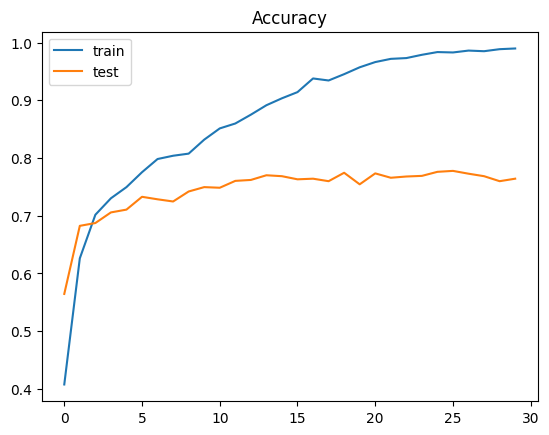

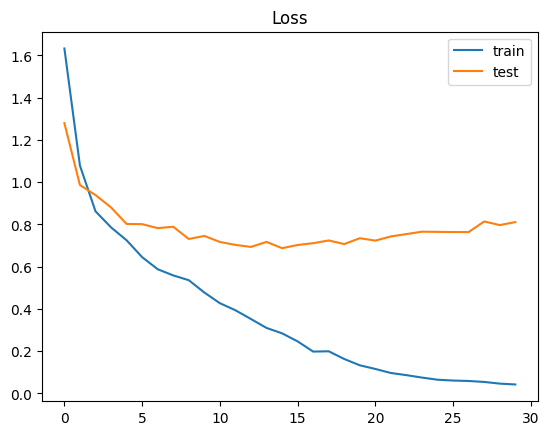

In [23]:
params["training_epochs"] = 30
history = train_model(params, training_model, dataset_train_preprocessed, dataset_val_preprocessed)
clear_output(wait=True)
plot_history(history)


Despite implementing regularization strategies such as dropout and reducing the batch size, the model appears to continue exhibiting overfitting tendencies. I am now proceeding to fine-tune the model, with the hope that this step might potentially resolve the issue.

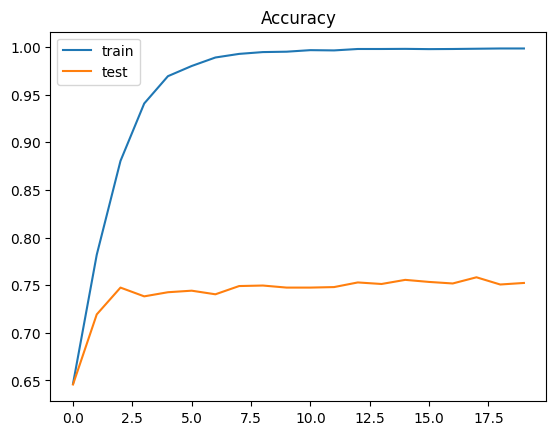

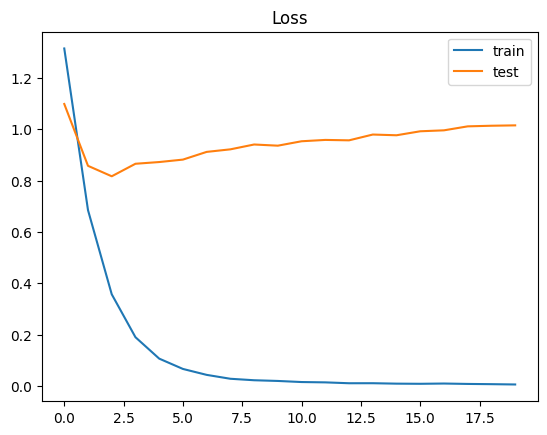

In [24]:
# Unfreeze all layers (i.e. make embeddings trainable)
training_model.trainable = True
training_model.summary()
re_compile_model(params, training_model)
params["training_epochs"] = 20
history = train_model(params, training_model, dataset_train_preprocessed, dataset_val_preprocessed)
clear_output(wait=True)
plot_history(history)

#5. Evaluation of the model
1. Check performance on all data.

161/161 [==============================] - 16s 68ms/step
Set Population: 10273
Accuracy: 0.9312


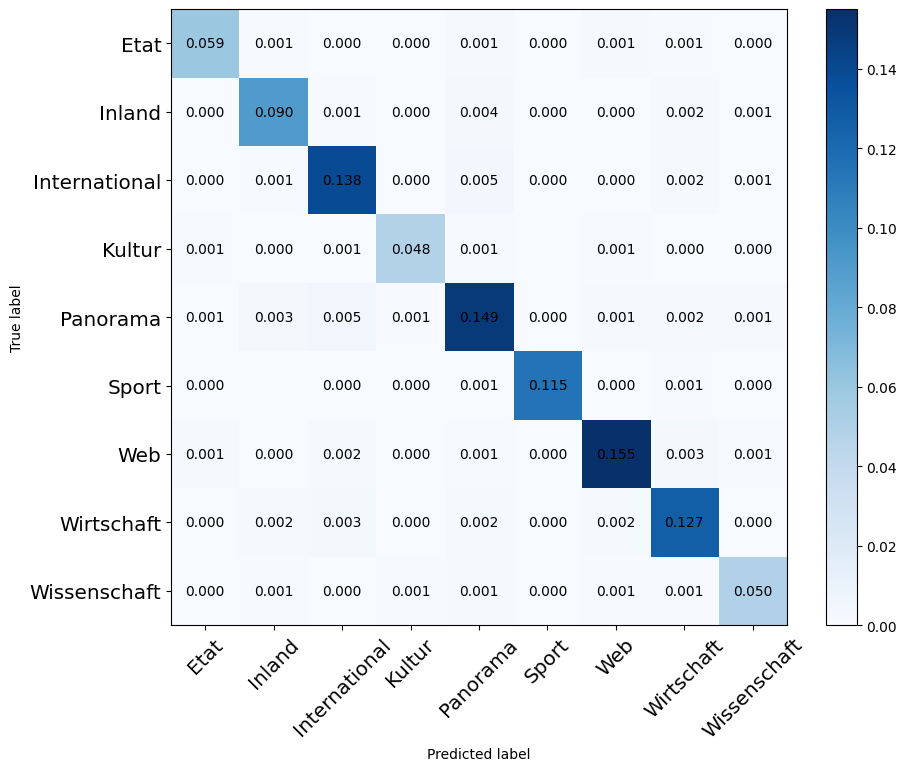

               precision    recall  f1-score   support

         Etat       0.93      0.91      0.92       668
       Inland       0.91      0.91      0.91      1015
International       0.92      0.94      0.93      1511
       Kultur       0.94      0.92      0.93       539
     Panorama       0.91      0.91      0.91      1678
        Sport       0.99      0.98      0.98      1201
          Web       0.95      0.95      0.95      1677
   Wirtschaft       0.92      0.92      0.92      1411
 Wissenschaft       0.92      0.89      0.90       573

     accuracy                           0.93     10273
    macro avg       0.93      0.93      0.93     10273
 weighted avg       0.93      0.93      0.93     10273

CPU times: user 18.1 s, sys: 662 ms, total: 18.8 s
Wall time: 16.6 s


In [27]:
%%time

preprocessor = create_text_preprocessor(params, False)

y, y_pred, y_pred_prob = predict_classification(params, data, training_model, preprocessor)
report_classification_results(params, y, y_pred)

2. Check performance on test data.

17/17 [==============================] - 1s 65ms/step
Set Population: 1028
Accuracy: 0.7695


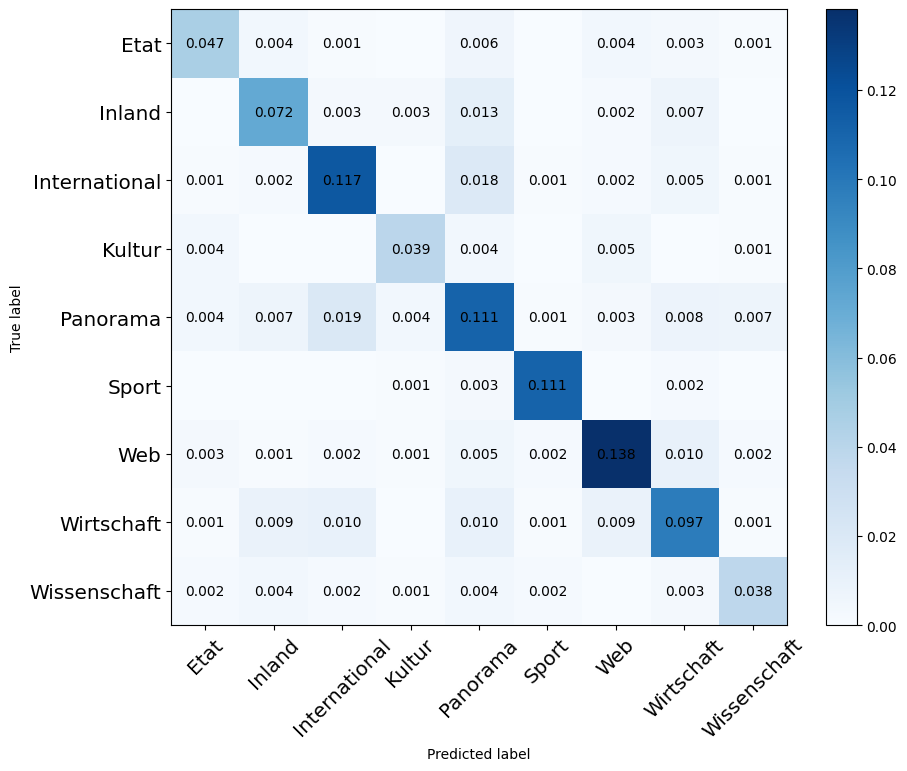

               precision    recall  f1-score   support

         Etat       0.76      0.72      0.74        67
       Inland       0.73      0.73      0.73       102
International       0.76      0.79      0.78       151
       Kultur       0.80      0.74      0.77        54
     Panorama       0.64      0.68      0.66       168
        Sport       0.94      0.95      0.95       120
          Web       0.85      0.85      0.85       168
   Wirtschaft       0.72      0.71      0.72       141
 Wissenschaft       0.75      0.68      0.72        57

     accuracy                           0.77      1028
    macro avg       0.77      0.76      0.77      1028
 weighted avg       0.77      0.77      0.77      1028

CPU times: user 1.93 s, sys: 245 ms, total: 2.17 s
Wall time: 1.77 s


In [29]:
%%time

preprocessor = create_text_preprocessor(params, False)

y, y_pred, y_pred_prob = predict_classification(params, data_test, training_model, preprocessor)

report_classification_results(params, y, y_pred)

In my lectures, I learned about a notable characteristic of Recurrent Neural Networks (RNNs) - their limited ability to effectively "remember" past words over long sequences. This limitation is primarily due to the nature of their hidden states, which are not particularly efficient at retaining information about words from the distant past within a sequence. Given this understanding, I was initially skeptical about the model's potential performance, especially since each text in my dataset contains several hundred tokens. Therefore, the fact that the model performed well was quite impressive and somewhat unexpected, considering the inherent memory constraints of RNNs.

# &#10132; F1 macro avg = 0.77

Given the dataset's imbalance, I've focused on the macro average F1 score as a key performance indicator. With a score of 0.77, this metric effectively reflects the RNN model's balanced precision and recall, making it an essential point of comparison against other models like BERT and the base model."